In [1]:
from datasets import load_dataset
# open-r1/OpenR1-Math-cn_k12-86k
openr1_source = load_dataset("open-r1/OpenR1-Math-220k", "extended")
cn_k12_86k =  openr1_source.filter(lambda example: example["source"] == "cn_k12", num_proc=32)
# cn_k12_86k.push_to_hub("Neelectric/OpenR1-Math-cn_k12-86k")
# cn_k12_86k['train'][0]

/Users/s2011847/repos/open-r1_olmo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-2-1124-7B-Instruct")
first = cn_k12_86k["train"][0]
tokenizer.chat_template = "{{ bos_token }}{% for message in messages %}{% if loop.first and messages[0]['role'] != 'system' %}{{ '<|system|>\nYou are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>\n...\n</think>\n<answer>\n...\n</answer>\n<|user|>' + message['content'] + '\n' }}{% elif message['role'] == 'system' %}{{ '<|system|>\n' + message['content'] + '\n' }}{% elif message['role'] == 'user' %}{{ '<|user|>\n' + message['content'] + '\n' }}{% elif message['role'] == 'assistant' %}{% if not loop.last %}{{ '<|assistant|>\n'  + message['content'] + eos_token + '\n' }}{% else %}{{ '<|assistant|>\n'  + message['content'] + eos_token }}{% endif %}{% endif %}{% if loop.last and add_generation_prompt %}{{ '<|assistant|>\n' }}{% endif %}{% endfor %}"
templated = tokenizer.apply_chat_template(first["messages"], tokenize=True)
print(len(templated))
# for elt in templated:
#     print(elt)

6530


In [21]:
# print(first)

In [22]:
tokenized = cn_k12_86k.map(
    lambda x: {"tokenized": tokenizer.apply_chat_template(x["messages"], tokenize=True, truncation=False, add_generation_prompt=False, return_tensors="np")},
    num_proc=32,
    keep_in_memory=True,
    # remove_columns=['problem', 'solution', 'answer', 'problem_type', 'question_type', 'source', 'uuid', 'is_reasoning_complete', 'generations', 'correctness_math_verify', 'correctness_llama', 'finish_reasons', 'correctness_count', "messages"]
    )

Map (num_proc=32): 100%|██████████| 91449/91449 [14:31<00:00, 104.94 examples/s] 


In [23]:
print(tokenized["train"])

Dataset({
    features: ['problem', 'solution', 'answer', 'problem_type', 'question_type', 'source', 'uuid', 'is_reasoning_complete', 'generations', 'correctness_math_verify', 'correctness_llama', 'finish_reasons', 'correctness_count', 'messages', 'tokenized'],
    num_rows: 91449
})


In [24]:
print(len(tokenized["train"]["tokenized"][0]))
tokenized["train"]["tokenized"][0]

1


[[100257,
  27,
  91,
  9125,
  91,
  397,
  2675,
  527,
  264,
  11190,
  15592,
  22103,
  430,
  5825,
  1664,
  5621,
  1525,
  291,
  323,
  11944,
  14847,
  13,
  1472,
  1176,
  1781,
  922,
  279,
  33811,
  1920,
  439,
  459,
  5419,
  1647,
  77828,
  323,
  1243,
  3493,
  279,
  1217,
  449,
  279,
  4320,
  13,
  40633,
  304,
  279,
  2768,
  3645,
  25,
  366,
  27963,
  397,
  9522,
  524,
  27963,
  397,
  27,
  9399,
  397,
  9522,
  524,
  9399,
  397,
  27,
  91,
  882,
  91,
  29,
  791,
  24524,
  315,
  279,
  12960,
  449,
  37442,
  362,
  4172,
  18,
  11,
  482,
  16,
  8,
  323,
  426,
  7,
  20,
  11,
  220,
  20,
  8,
  439,
  279,
  23899,
  374,
  33771,
  627,
  27,
  91,
  78191,
  91,
  397,
  14023,
  771,
  397,
  33413,
  11,
  779,
  358,
  1205,
  311,
  1505,
  279,
  24524,
  315,
  264,
  12960,
  1405,
  279,
  37442,
  315,
  279,
  23899,
  527,
  2728,
  439,
  3585,
  362,
  4172,
  18,
  11,
  482,
  16,
  8,
  323,
  426,
  7,
  20,


In [25]:
flattened = [inner_list[0] for inner_list in tokenized["train"]["tokenized"]]
len(flattened[0])

2137

In [26]:
lengths = [len(item) for item in flattened]  # Calculate the lengths of each list

# Count the number of prompts longer than 4096 tokens
long_prompts_count = sum(1 for length in lengths if length > 4096)

print(f"Number of prompts longer than 4096 tokens: {long_prompts_count}")

Number of prompts longer than 4096 tokens: 22317


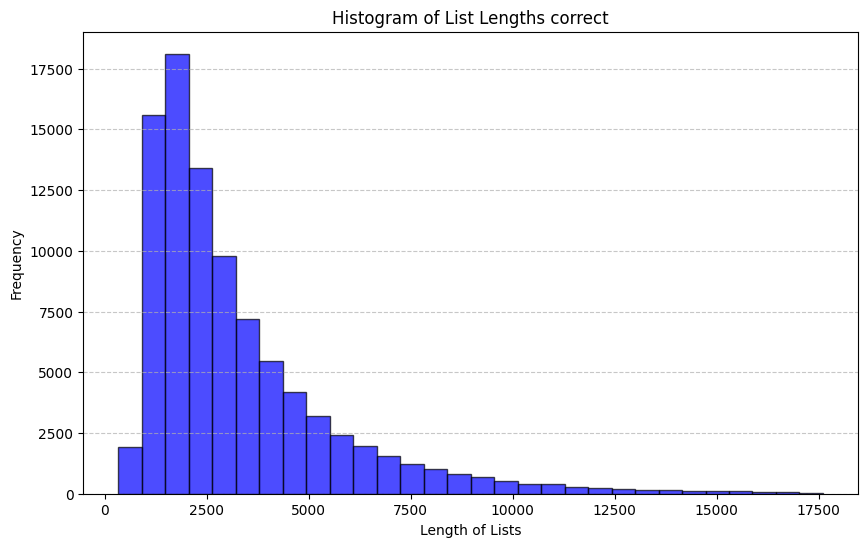

In [27]:
import matplotlib.pyplot as plt

# Assuming `flattened` is your list of lists
lengths = [len(item) for item in flattened]  # Calculate the lengths of each list

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of List Lengths correct')
plt.xlabel('Length of Lists')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [28]:
prompts_left = sum(1 for length in lengths if length < 4096)

print(f"Number of prompts longer than 4096 tokens: {prompts_left}")

Number of prompts longer than 4096 tokens: 69122


In [29]:
filtered = tokenized.filter(lambda example: len(example["tokenized"]) <=4096, num_proc=32)

Filter (num_proc=32): 100%|██████████| 91449/91449 [00:24<00:00, 3693.58 examples/s]


In [31]:
print(filtered['train'][0])

{'problem': 'The equation of the circle with endpoints A(-3, -1) and B(5, 5) as the diameter is ______.', 'solution': "First, let's find the center of the circle which is the midpoint of the line segment AB. The midpoint ($x_m$, $y_m$) can be found using the midpoint formula:\n$$ x_m = \\frac{x_A + x_B}{2}, \\quad y_m = \\frac{y_A + y_B}{2} $$\n\nSubstituting the given coordinates A(-3, -1) and B(5, 5), we get:\n$$ x_m = \\frac{-3 + 5}{2} = \\frac{2}{2} = 1 $$\n$$ y_m = \\frac{-1 + 5}{2} = \\frac{4}{2} = 2 $$\n\nThus, the center of the circle (C) is C(1, 2).\n\nNext, we need to find the radius of the circle. The radius is half the distance between A and B, so let's calculate the distance (d) first:\n$$ d = \\sqrt{(x_B - x_A)^2 + (y_B - y_A)^2} $$\n\nPlugging in the coordinates of A and B,\n$$ d = \\sqrt{(5 - (-3))^2 + (5 - (-1))^2} $$\n$$ d = \\sqrt{(5 + 3)^2 + (5 + 1)^2} $$\n$$ d = \\sqrt{8^2 + 6^2} $$\n$$ d = \\sqrt{64 + 36} $$\n$$ d = \\sqrt{100} $$\n$$ d = 10 $$\n\nThe radius (r) i

In [ ]:
# filtered = filtered.remove_columns("tokenized")

In [32]:
filtered.push_to_hub("Neelectric/OpenR1-Math-220k_CN-K12_OLMo4096toks")

Uploading the dataset shards: 100%|██████████| 11/11 [01:24<00:00,  7.72s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Neelectric/OpenR1-Math-220k_CN-K12_OLMo4096toks/commit/79ae8b112ce82aea712222ba38cc2388449d8cad', commit_message='Upload dataset', commit_description='', oid='79ae8b112ce82aea712222ba38cc2388449d8cad', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Neelectric/OpenR1-Math-220k_CN-K12_OLMo4096toks', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Neelectric/OpenR1-Math-220k_CN-K12_OLMo4096toks'), pr_revision=None, pr_num=None)